# Clustering

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType

spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",IntegerType(),True), \
        StructField("FINAL_CAR_KEY", IntegerType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

22/02/08 13:29:01 WARN Utils: Your hostname, jupyter resolves to a loopback address: 127.0.1.1; using 172.16.199.17 instead (on interface eth0)
22/02/08 13:29:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/08 13:29:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv('Traffic.csv',header=True,schema=schema)
df.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|
|        155|       81|       87625017|     87625017|               5|       161|2021-06-01 04:14:21|
|     631757|       81|        8652928|      8652928|               5|       161|2021-06-01 03:58:57|
|     631757|       81|        8548123|      8548123|               5|       161|2021-06-01 04:01:38|
|     631757|       81|       24715264|     24715264|               5|       161|2021-06-01 03:56:57|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 5 rows



In [3]:
from pyspark.sql.functions import dayofyear

df = df.withColumn('day', dayofyear(df.PASS_DAY_TIME))
df = df.filter(df.day != 159)
df.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|152|
|        155|       81|       87625017|     87625017|               5|       161|2021-06-01 04:14:21|152|
|     631757|       81|        8652928|      8652928|               5|       161|2021-06-01 03:58:57|152|
|     631757|       81|        8548123|      8548123|               5|       161|2021-06-01 04:01:38|152|
|     631757|       81|       24715264|     24715264|               5|       161|2021-06-01 03:56:57|152|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
only showing top 5 rows



In [4]:
from pyspark.sql.functions import col,current_timestamp,to_date,hour,dayofweek

df_with_time_columns = df.withColumn('weekday', dayofweek(df.PASS_DAY_TIME))
df_with_time_columns = df_with_time_columns.withColumn('hour', hour(df.PASS_DAY_TIME))
df_with_time_columns = df_with_time_columns.select('DEVICE_CODE', 'FINAL_CAR_KEY', 'weekday', 'hour')
df_with_time_columns.show(5)

+-----------+-------------+-------+----+
|DEVICE_CODE|FINAL_CAR_KEY|weekday|hour|
+-----------+-------------+-------+----+
|     200501|     10477885|      3|   3|
|        155|     87625017|      3|   4|
|     631757|      8652928|      3|   3|
|     631757|      8548123|      3|   4|
|     631757|     24715264|      3|   3|
+-----------+-------------+-------+----+
only showing top 5 rows



In [5]:
camera_daily_df = df_with_time_columns.groupBy(
    'DEVICE_CODE',
    'weekday',
    'hour'
).count()
camera_daily_df.show(5)

+-----------+-------+----+-----+
|DEVICE_CODE|weekday|hour|count|
+-----------+-------+----+-----+
|     631763|      3|   1|   89|
|        125|      3|   0|    1|
|        169|      3|   6|  197|
|     631776|      3|   4|    7|
|     900222|      3|   0|  263|
+-----------+-------+----+-----+
only showing top 5 rows



In [6]:
from pyspark.ml.feature import StringIndexer

camera_daily_indexed_df = StringIndexer(inputCol='DEVICE_CODE', outputCol='camera').fit(camera_daily_df).transform(camera_daily_df)
camera_daily_indexed_df.show(5)

+-----------+-------+----+-----+------+
|DEVICE_CODE|weekday|hour|count|camera|
+-----------+-------+----+-----+------+
|     631763|      3|   1|   89| 652.0|
|        125|      3|   0|    1| 604.0|
|        169|      3|   6|  197|  74.0|
|     631776|      3|   4|    7| 494.0|
|     900222|      3|   0|  263| 217.0|
+-----------+-------+----+-----+------+
only showing top 5 rows



In [ ]:
# from pyspark.mllib.linalg.distributed import CoordinateMatrix

# camera_traffic_matrix = CoordinateMatrix(camera_daily_indexed_df.rdd.map(lambda x: (
#     int(x['camera']), 
#     (x['weekday']-1)*24 + x['hour'],
#     x['count'] 
#     )))


# camera_traffic_matrix.toRowMatrix().rows.take(1)

# from pyspark.mllib.clustering import LDA

# lda_model = LDA.train(camera_traffic_matrix.toRowMatrix().rows.map(lambda x: 
# (1, x)
# ), k = 2)
# topics = lda_model.topicsMatrix()
# topics

In [7]:
def convert_to_vector(x):
    camera = x[0]
    daily_list = x[1]
    vector = [0]*24*7
    for y in daily_list:
        index = y[0]
        count = y[1]
        vector[index] = count

    return (camera, vector)


camera_vectors = camera_daily_df.rdd.map(lambda x: 
    (
    x['DEVICE_CODE'], 
    (
        (x['weekday']-1)*24 + x['hour'],
         x['count']
    )
    )
).groupByKey().mapValues(list).map(convert_to_vector)

camera_vectors.take(5)

[(631776,
  [54,
   17,
   11,
   12,
   10,
   11,
   21,
   48,
   70,
   93,
   125,
   159,
   187,
   158,
   112,
   74,
   104,
   170,
   223,
   241,
   251,
   226,
   56,
   0,
   0,
   9,
   11,
   7,
   10,
   23,
   66,
   166,
   185,
   157,
   179,
   160,
   148,
   140,
   149,
   196,
   341,
   483,
   594,
   452,
   315,
   182,
   83,
   45,
   22,
   14,
   8,
   6,
   7,
   18,
   54,
   172,
   148,
   128,
   193,
   162,
   170,
   131,
   180,
   185,
   379,
   547,
   558,
   547,
   370,
   246,
   88,
   38,
   23,
   19,
   6,
   12,
   6,
   30,
   64,
   167,
   141,
   151,
   189,
   194,
   165,
   146,
   173,
   189,
   333,
   489,
   564,
   467,
   348,
   238,
   87,
   57,
   28,
   23,
   11,
   7,
   12,
   17,
   44,
   101,
   125,
   133,
   165,
   148,
   232,
   380,
   281,
   143,
   152,
   101,
   243,
   232,
   223,
   233,
   92,
   67,
   56,
   34,
   18,
   25,
   16,
   13,
   24,
   43,
   70,
   97,
   127,
   168,
   

In [10]:
from pyspark.mllib.clustering import LDA
from pyspark.mllib.linalg import Vectors

cluster_count = 3
lda_model = LDA.train(camera_vectors.map(lambda x: [x[0], Vectors.dense(x[1])]), k = cluster_count)
clusters = lda_model.topicsMatrix()
clusters

array([[ 36412.59928832,  20221.78396811,   8935.61674357],
       [ 24555.85354294,  13419.70439913,   6605.44205793],
       [ 14673.99915639,   7392.00902947,   3371.99181414],
       [ 13726.13698872,   7086.32182457,   3943.54118671],
       [ 10648.95895535,   5625.1085757 ,   2289.93246896],
       [ 15316.34380826,   7848.22733288,   4253.42885886],
       [ 33130.49938359,  18280.96271819,  10534.53789821],
       [ 44019.40727154,  29565.92658836,  18135.66614011],
       [ 53194.30835069,  36317.90755257,  22938.78409674],
       [ 64074.5097835 ,  44904.26990512,  30937.22031139],
       [ 76319.34430559,  61325.0102872 ,  46188.64540722],
       [ 92362.13206068,  71970.60086243,  57073.26707689],
       [ 99464.76044555,  75375.54174115,  59402.6978133 ],
       [ 93599.85397947,  73981.93512656,  49077.21089397],
       [ 80992.07130767,  66184.30793722,  44884.62075511],
       [ 81374.42176182,  57570.4858093 ,  36999.09242888],
       [ 89013.9573849 ,  66583.50857462

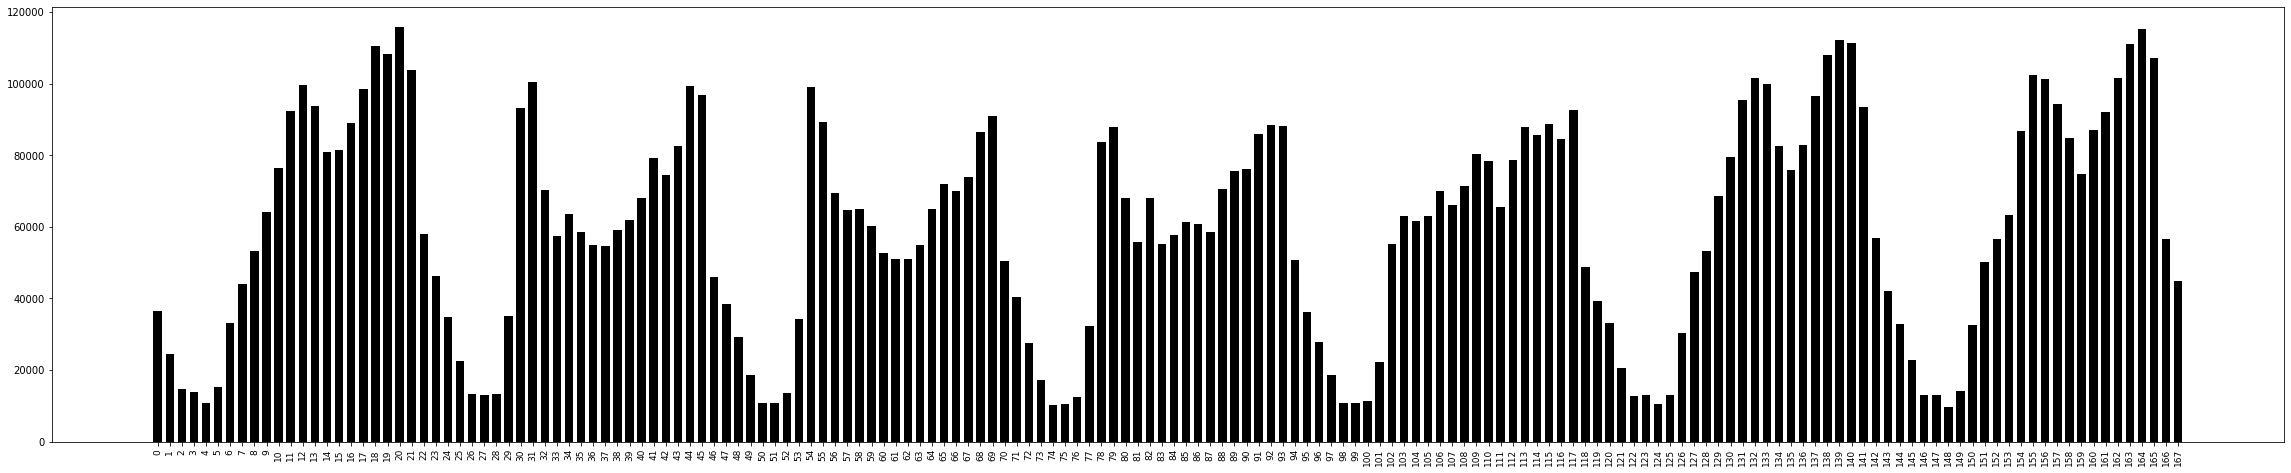

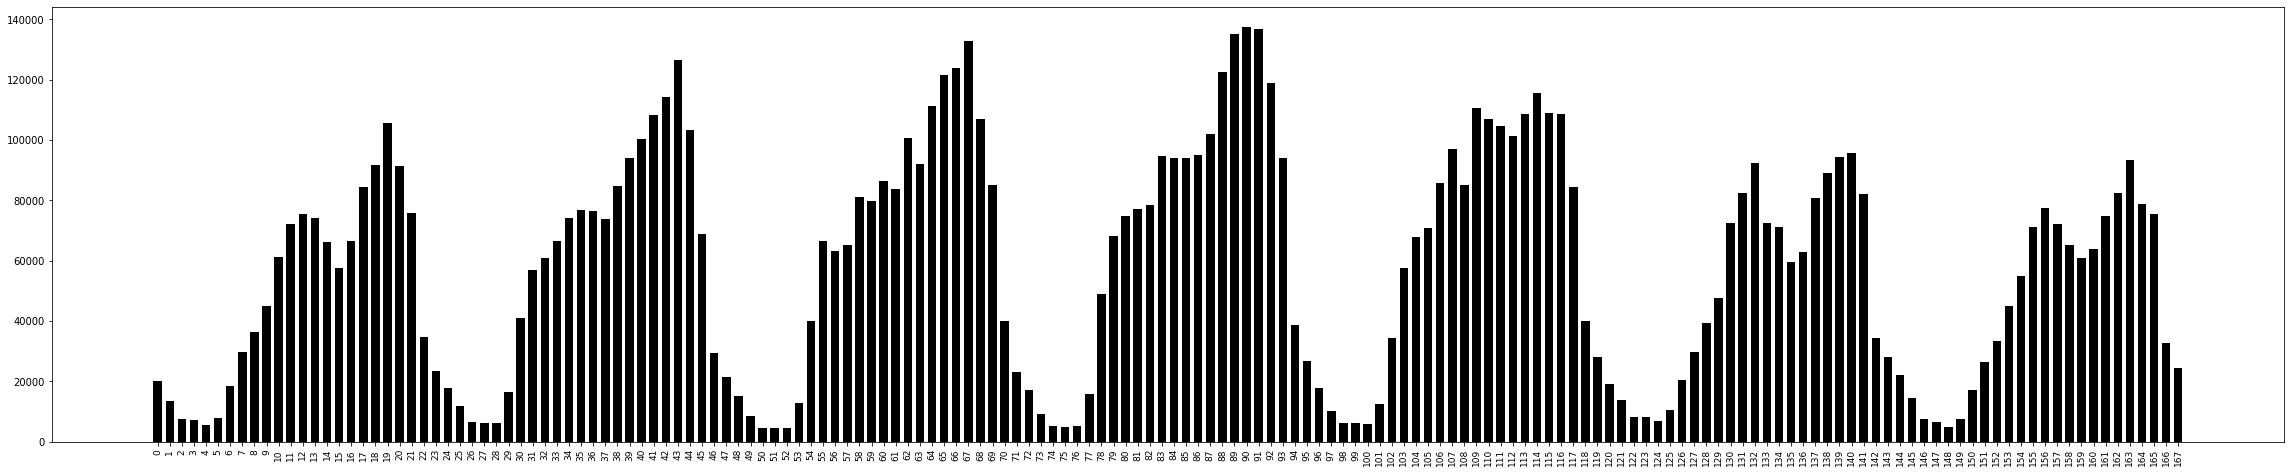

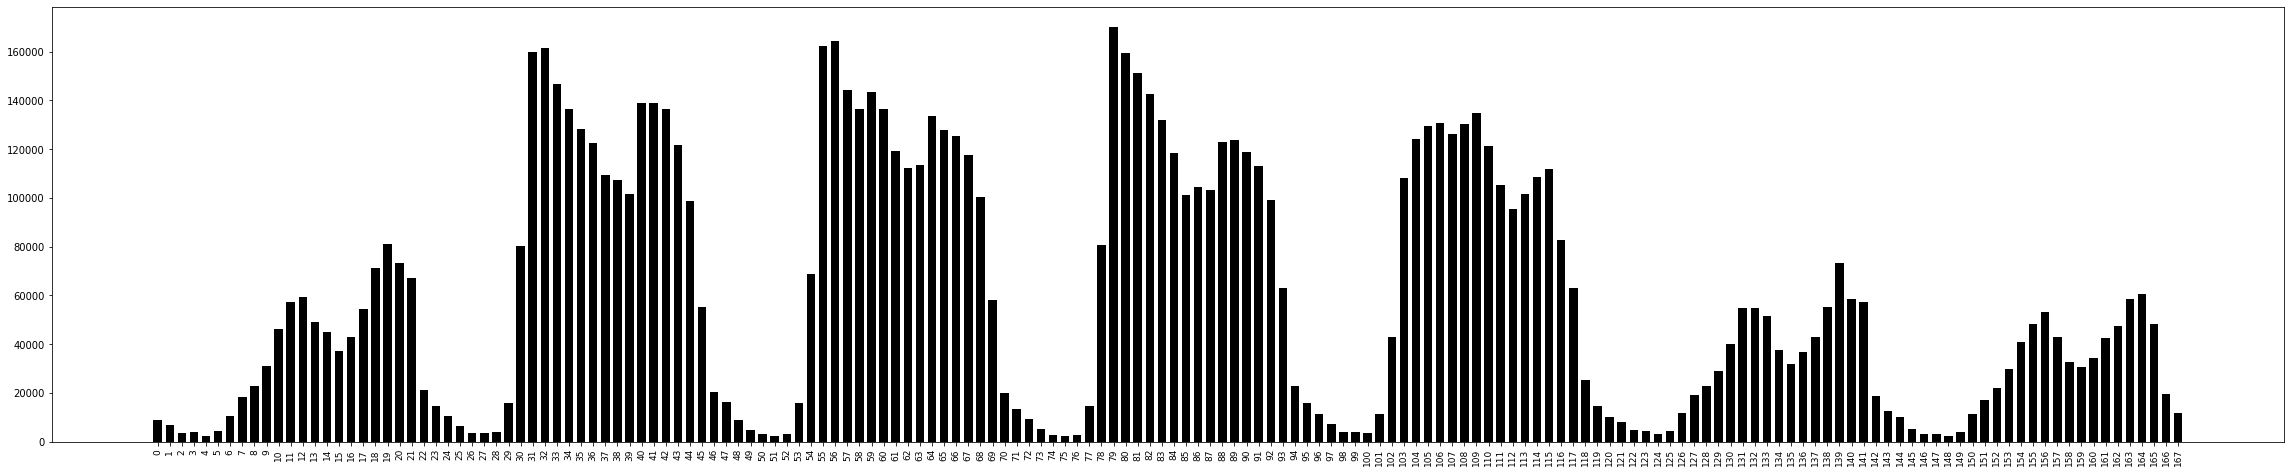

In [11]:
import matplotlib.pyplot as plt
for cluster in range(cluster_count):
      fig = plt.figure(figsize = (40, 8))
      labels = list(map(lambda x: str(x), range(24*7)))
      plt.bar(labels, clusters[:,cluster], color ='black', width = 0.7)
      plt.xticks(rotation='vertical', fontsize=9)
      plt.show()